# Introduction to Data Science Long Assignment 2024/2025
## Predicting Health Insurance

## Data reading

In [441]:
import pandas as pd
import numpy as np

data = pd.read_csv('customer.csv')
data.reset_index(drop=True, inplace=True)

## Initial analysis

In [442]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import math

In [443]:
data.head()

,Unnamed: 0,custid,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,code_column,gas_usage,rooms,recent_move_b
0,7,000006646_03,Male,True,22000.0,Never married,True,Homeowner free and clear,0.0,24,Alabama,1047,210.0,3,F
1,8,000007827_01,Female,NaN,23200.0,Divorced/Separated,True,Rented,0.0,82,Alabama,1047,3.0,6,T
2,9,000008359_04,Female,True,21000.0,Never married,True,Homeowner with mortgage/loan,2.0,31,Alabama,1047,40.0,3,F
3,10,000008529_01,Female,NaN,37770.0,Widowed,True,Homeowner free and clear,1.0,93,Alabama,1047,120.0,2,F
4,11,000008744_02,Male,True,39000.0,Divorced/Separated,True,Rented,2.0,67,Alabama,1047,3.0,2,F


In [444]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72458 entries, 0 to 72457
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      72458 non-null  int64  
 1   custid          72458 non-null  object 
 2   sex             72458 non-null  object 
 3   is_employed     46943 non-null  object 
 4   income          72458 non-null  float64
 5   marital_status  72458 non-null  object 
 6   health_ins      72458 non-null  bool   
 7   housing_type    70772 non-null  object 
 8   num_vehicles    70772 non-null  float64
 9   age             72458 non-null  int64  
 10  state_of_res    72458 non-null  object 
 11  code_column     72458 non-null  int64  
 12  gas_usage       70772 non-null  float64
 13  rooms           72458 non-null  int64  
 14  recent_move_b   70771 non-null  object 
dtypes: bool(1), float64(3), int64(4), object(7)
memory usage: 7.8+ MB


In [445]:
# The Unnamed: 0 column resulted from saving the csv file so it can be dropped
data.drop('Unnamed: 0', axis=1, inplace=True) 

# Drop the custid column (its an ID)
data.drop("custid", axis=1, inplace=True)

In [446]:
data.isna().sum()

sex                   0
is_employed       25515
income                0
marital_status        0
health_ins            0
housing_type       1686
num_vehicles       1686
age                   0
state_of_res          0
code_column           0
gas_usage          1686
rooms                 0
recent_move_b      1687
dtype: int64

In [447]:
# Replace the null values in the 'is_employed' column with 'False' (empty means no employment)
data.fillna({'is_employed': 'False'}, inplace=True)

In [448]:
# In the dictionary, we are indicated that the values 1, 2, 3 indicate special cases which we decided to separate
data['gas_payment'] = data['gas_usage'].replace([x for x in data['gas_usage'] if x not in [1, 2, 3]], 0)
data['gas_bill'] = data['gas_usage'].replace([x for x in data['gas_usage'] if x in [1, 2, 3]], 0)

In [449]:
# Print the columns with missing values
print(f' --- PRE CLEANING --- \nColumns with missing values: \n{data.isna().sum()}')
old_len = len(data)
print('Length of the dataframe: ', old_len)   

# Drop the rest of the rows with missing values
data.dropna(axis=0, inplace=True)

print(f'\n --- POST CLEANING --- \nLength of the dataframe: {len(data)}')
print('Number of rows dropped: ', old_len - len(data))

 --- PRE CLEANING --- 
Columns with missing values: 
sex                  0
is_employed          0
income               0
marital_status       0
health_ins           0
housing_type      1686
num_vehicles      1686
age                  0
state_of_res         0
code_column          0
gas_usage         1686
rooms                0
recent_move_b     1687
gas_payment          0
gas_bill          1686
dtype: int64
Length of the dataframe:  72458

 --- POST CLEANING --- 
Length of the dataframe: 70771
Number of rows dropped:  1687


health_ins
True     64338
False     6433
Name: count, dtype: int64


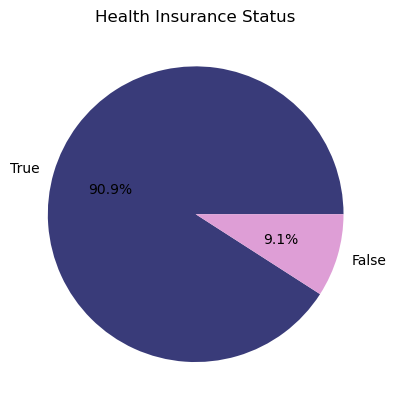

In [450]:
print(data.health_ins.value_counts())

data.health_ins.value_counts().plot(kind='pie', 
                                    autopct='%1.1f%%', 
                                    title='Health Insurance Status',
                                    ylabel='',
                                    colormap='tab20b')
                                    
plt.show()

In [451]:
# We can see all the different scales of the int columns of the data
data.describe()

,income,num_vehicles,age,code_column,gas_usage,rooms,gas_payment,gas_bill
count,7.077100e+04,70771.000000,70771.000000,70771.000000,70771.000000,70771.000000,70771.000000,70771.000000
mean,4.263217e+04,2.066849,49.214113,3289.410832,41.231041,3.495146,1.264642,39.966399
std,5.864206e+04,1.170058,17.932735,2663.474061,63.149606,1.706561,1.393938,63.929786
min,-6.900000e+03,0.000000,0.000000,131.000000,1.000000,1.000000,0.000000,0.000000
25%,1.130000e+04,1.000000,34.000000,1305.000000,3.000000,2.000000,0.000000,0.000000
50%,2.749000e+04,2.000000,48.000000,2269.000000,10.000000,3.000000,0.000000,10.000000
75%,5.206000e+04,3.000000,62.000000,4979.000000,60.000000,5.000000,3.000000,60.000000
max,1.257000e+06,6.000000,120.000000,8962.000000,570.000000,6.000000,3.000000,570.000000


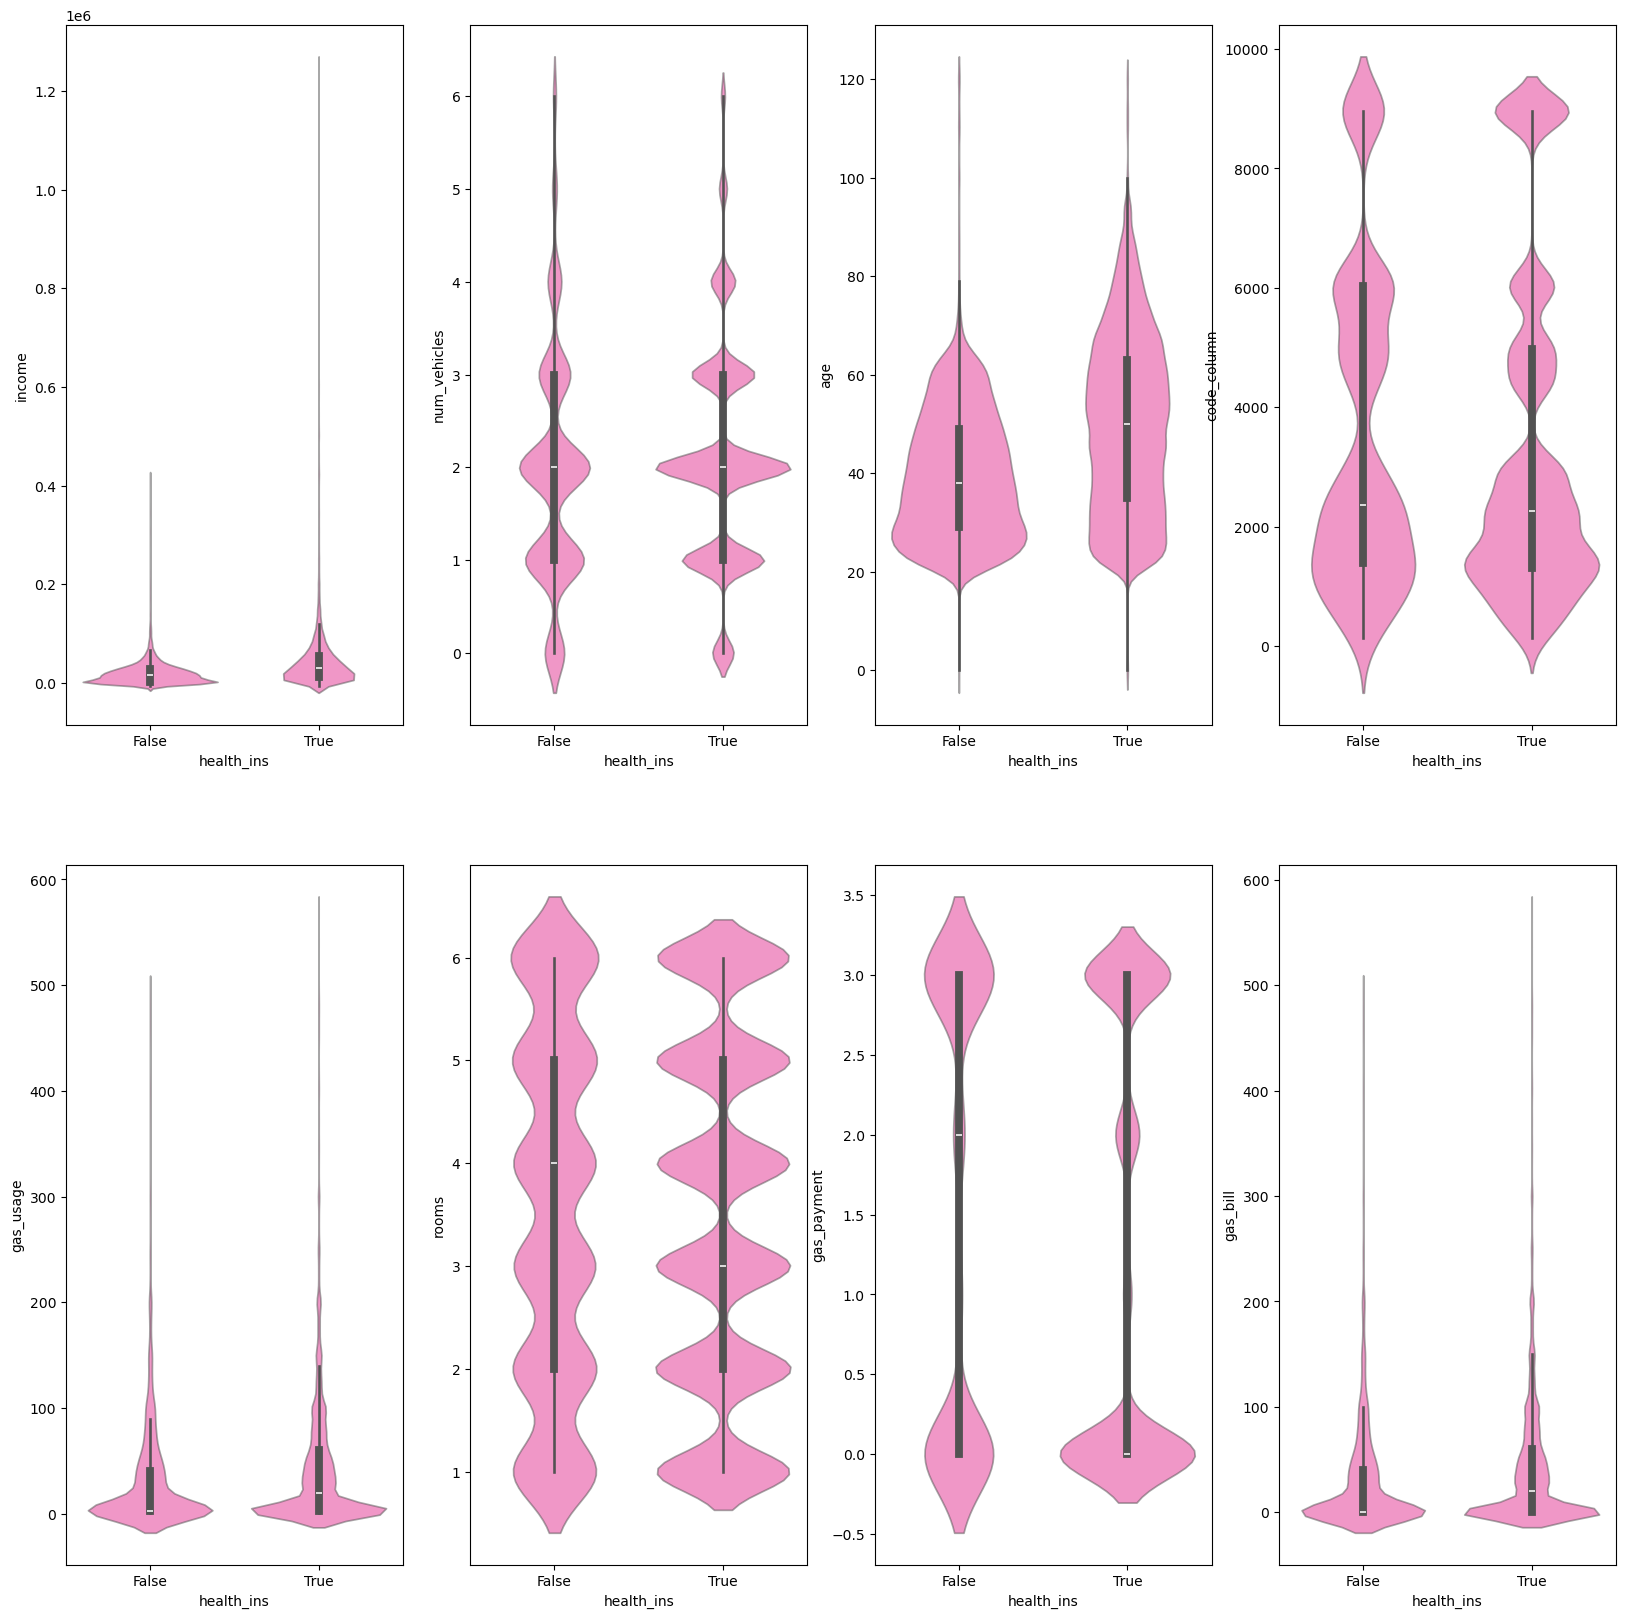

In [452]:
fig, ax = plt.subplots(2,4, figsize = (20,20))

for i, col in enumerate(data.select_dtypes(include = ['float64', 'int64']).columns):
    sns.violinplot(data=data,x = 'health_ins', y = col, ax=ax[i//4, i%4], color='deeppink', alpha=0.5)
plt.show()

In [453]:
# Columns chosen to be normalized
cols_norm = ['income', 'gas_bill']

c:\Users\castr\anaconda3\envs\IAP2\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


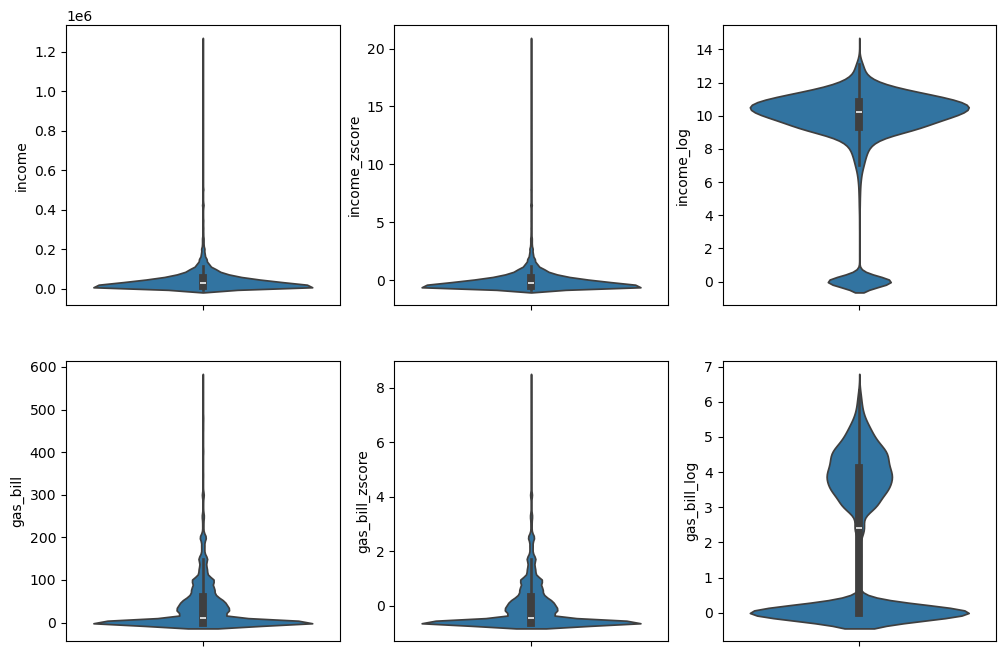

In [454]:
fig, ax = plt.subplots(2,3, figsize=(12,8))

for i, col in enumerate(cols_norm):
    data[f'{col}_zscore'] = data[[col]].apply(zscore)
    data[f'{col}_log'] = np.log1p(data[col])

    sns.violinplot(data=data[col], ax = ax[i, 0])
    sns.violinplot(data=data[f'{col}_zscore'], ax = ax[i, 1])
    sns.violinplot(data=data[f'{col}_log'], ax = ax[i, 2])
plt.show()

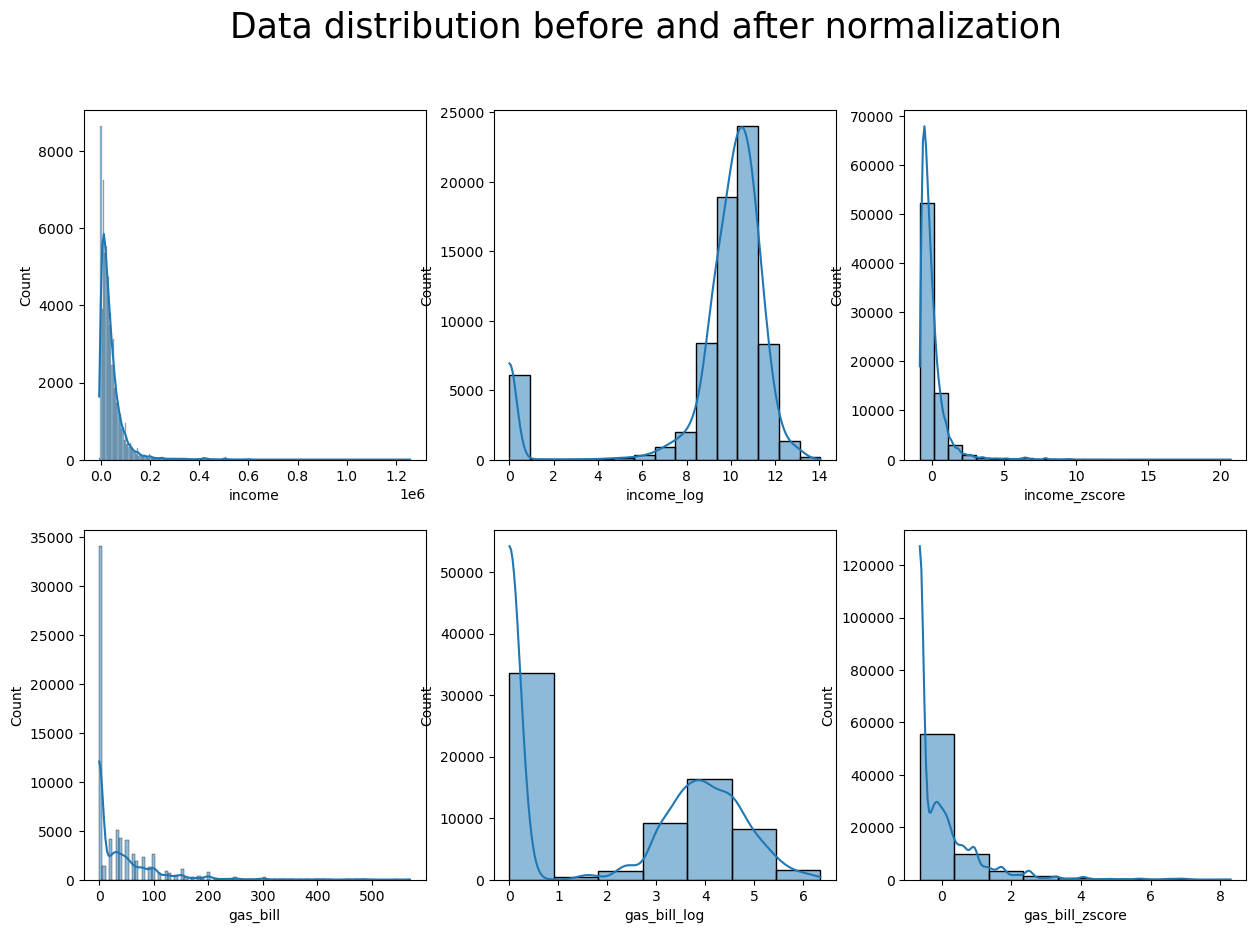

In [455]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
fig.suptitle('Data distribution before and after normalization', fontsize=25)

for i, col in enumerate(cols_norm):
    # Use scott's method to determine the number of bins (used in excel and R)
    width = math.ceil(3.5 * (data[col].std()) / (math.pow(len(data), 1/3)))
    n = math.ceil((data[col].max() - data[col].min()) / width)

    sns.histplot(data=data[col], 
                 ax = ax[i, 0], 
                 bins=n,
                 kde=True)

    width = math.ceil(3.5 * (data[f'{col}_log'].std()) / (math.pow(len(data), 1/3)))
    n = math.ceil((data[f'{col}_log'].max() - data[f'{col}_log'].min()) / width)

    sns.histplot(data=data[f'{col}_log'], 
                 ax = ax[i, 1],
                 bins=n, 
                 kde=True)
    
    width = math.ceil(3.5 * (data[f'{col}_zscore'].std()) / (math.pow(len(data), 1/3)))
    n = math.ceil((data[f'{col}_zscore'].max() - data[f'{col}_zscore'].min()) / width)

    sns.histplot(data=data[f'{col}_zscore'], 
                 ax = ax[i, 2],
                 bins=n, 
                 kde=True)
    
plt.show()

In [456]:
data.drop(['income', 'gas_bill', 'income_log', 'gas_bill_log', 'gas_usage'], inplace=True, axis=1)

In [457]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70771 entries, 0 to 72456
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sex              70771 non-null  object 
 1   is_employed      70771 non-null  object 
 2   marital_status   70771 non-null  object 
 3   health_ins       70771 non-null  bool   
 4   housing_type     70771 non-null  object 
 5   num_vehicles     70771 non-null  float64
 6   age              70771 non-null  int64  
 7   state_of_res     70771 non-null  object 
 8   code_column      70771 non-null  int64  
 9   rooms            70771 non-null  int64  
 10  recent_move_b    70771 non-null  object 
 11  gas_payment      70771 non-null  float64
 12  income_zscore    70771 non-null  float64
 13  gas_bill_zscore  70771 non-null  float64
dtypes: bool(1), float64(4), int64(3), object(6)
memory usage: 7.6+ MB


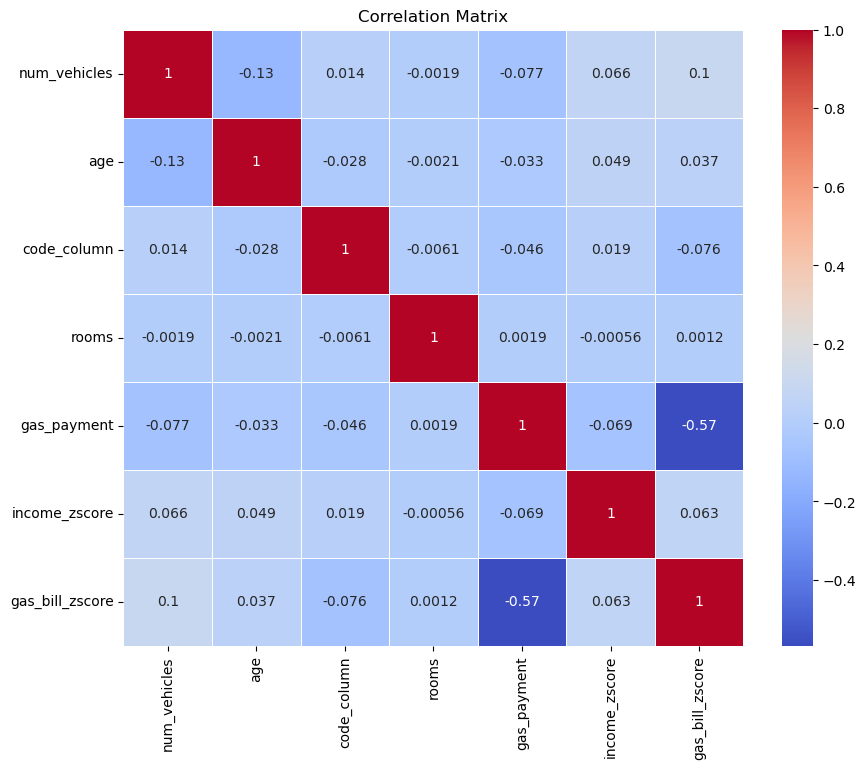

In [458]:
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numerical_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Point Biserial Correlation
- Age and income are highly statistically significant features
- Rooms shows no significant correlation with the binary class, given its very weak correlation and a high p-value

In [459]:
from scipy import stats


for col in numerical_data.columns:
    print('---', col, '---')
# Assuming 'code_column' is the numerical column and 'state_column' is binary
    correlation, p_value = stats.pointbiserialr(data[col], data['health_ins'])
    print("Point Biserial Correlation:", correlation)
    print("p-value:", p_value)

--- num_vehicles ---
Point Biserial Correlation: 0.03655066765175333
p-value: 2.322568967475042e-22
--- age ---
Point Biserial Correlation: 0.16432390359206991
p-value: 0.0
--- code_column ---
Point Biserial Correlation: -0.030629912828155338
p-value: 3.6335712838973943e-16
--- rooms ---
Point Biserial Correlation: -0.005954304129640254
p-value: 0.11319398400170269
--- gas_payment ---
Point Biserial Correlation: -0.058556176627665
p-value: 8.421022180471517e-55
--- income_zscore ---
Point Biserial Correlation: 0.12102803379655497
p-value: 4.285997849640218e-229
--- gas_bill_zscore ---
Point Biserial Correlation: 0.04380611890519337
p-value: 2.063234625417495e-31


In [460]:
data.drop('rooms', axis=1, inplace=True)
numerical_data.drop('rooms', axis=1, inplace=True)

## Feature engineering

In [461]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [462]:
data_knn = data.replace({'age': 0}, np.nan)

print(data_knn["age"].isna().sum())

76


In [463]:
num_cols = data_knn.select_dtypes(include=['float64', 'int64']).columns.to_list()

num_cols.remove('age')

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical data
data_knn[num_cols] = scaler.fit_transform(data_knn[num_cols])

In [464]:
data_knn = pd.get_dummies(data_knn, drop_first=True)
data_knn.head()

,health_ins,num_vehicles,age,code_column,gas_payment,income_zscore,gas_bill_zscore,sex_Male,is_employed_True,is_employed_False,...,state_of_res_Tennessee,state_of_res_Texas,state_of_res_Utah,state_of_res_Vermont,state_of_res_Virginia,state_of_res_Washington,state_of_res_West Virginia,state_of_res_Wisconsin,state_of_res_Wyoming,recent_move_b_T
0,True,-1.766462,24.0,-0.841918,-0.907251,-0.351835,2.659712,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,True,-1.766462,82.0,-0.841918,1.244941,-0.331371,-0.625165,False,False,True,...,False,False,False,False,False,False,False,False,False,True
2,True,-0.057134,31.0,-0.841918,-0.907251,-0.368887,0.000526,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,True,-0.911798,93.0,-0.841918,-0.907251,-0.082913,1.251907,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,True,-0.057134,67.0,-0.841918,1.244941,-0.061938,-0.625165,True,True,False,...,False,False,False,False,False,False,False,False,False,False


In [465]:
imputer = KNNImputer(n_neighbors=5)

imputed_data = pd.DataFrame(imputer.fit_transform(data_knn), columns=data_knn.columns)


In [466]:
imputed_data['age']

0        24.0
1        82.0
2        31.0
3        93.0
4        67.0
         ... 
70766    32.0
70767    25.0
70768    86.0
70769    50.0
70770    61.0
Name: age, Length: 70771, dtype: float64

In [467]:
imputed_data['age'] = np.round(imputed_data['age'])
imputed_data['age'].unique()

array([ 24.,  82.,  31.,  93.,  67.,  76.,  26.,  73.,  27.,  54.,  61.,
        64.,  55.,  65.,  33.,  47.,  68.,  46.,  58.,  43.,  41.,  62.,
        21.,  78.,  32.,  59.,  29.,  70.,  30.,  28.,  86.,  35.,  34.,
        40.,  72.,  60.,  25.,  79.,  22.,  42.,  44.,  81.,  50.,  45.,
        63.,  57.,  39.,  71.,  38.,  49.,  69.,  37.,  66.,  53.,  36.,
        23.,  75.,  88.,  51.,  85.,  52.,  83.,  77.,  56.,  48., 100.,
        74.,  89.,  80.,  84.,  87., 120.,  91., 110., 114.,  94.,  90.,
        96.,  92.,  95.])

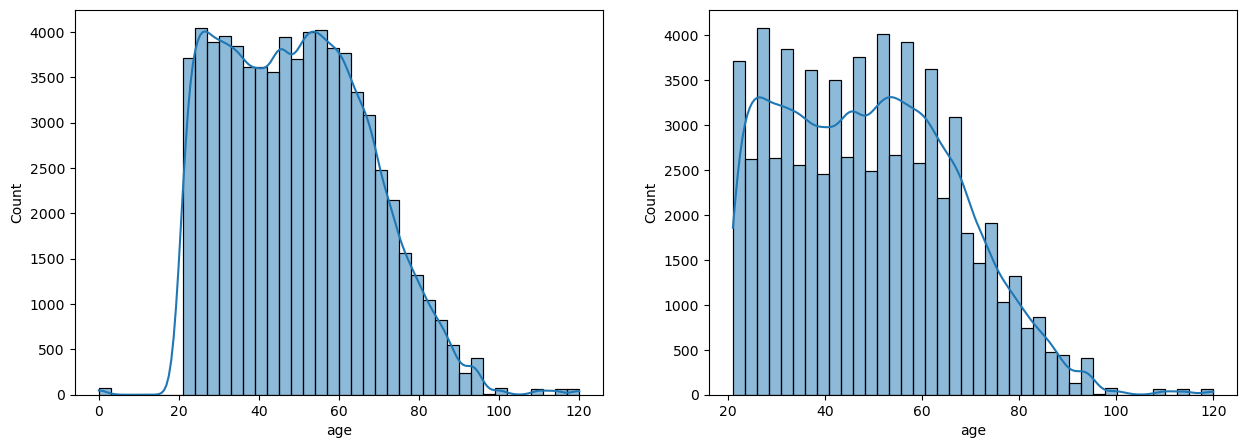

In [468]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

sns.histplot(data=data.age, bins=40, kde=True, ax=ax[0])

sns.histplot(data=imputed_data.age, bins=40, kde=True, ax=ax[1])
plt.show()

In [470]:
data['age'] = imputed_data['age']

## Model implementation